# Clasificador de EEG

## Importar librerías

In [1]:
#Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from matplotlib import mlab
from feature_extraction import statistics_feature_extraction as sfe
from importar_dataset import *

## Preparación del dataset

5 Usuarios que utilizan como clases brazo izquierdo y derecho:
- BCICIV_calib_ds1b.mat
- BCICIV_calib_ds1c.mat
- BCICIV_calib_ds1d.mat
- BCICIV_calib_ds1e.mat
- BCICIV_calib_ds1g.mat

Se eliminan los usuarios ds1a y ds1f porque utilizan un brazo y un pie como clases

In [2]:
# Cargado el archivo mat
m = leer("BCICIV_1_mat\BCICIV_calib_ds1g.mat")

# Extracción del estudio
EEG = m['cnt'].T
nchannels,nsamples = EEG.shape

# Extracción de los marcadores
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]

# Extracción de la información adicional
sample_rate = m['nfo']['fs'][0][0][0][0]
channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1,cl2 = cl_lab[0],cl_lab[1]
nclases = len(cl_lab)
neventos = len(event_onsets)

# Etiquetas de inicio de clases
labels = np.zeros((1,nsamples),int)
labels[0,event_onsets] = event_codes

In [3]:
# Despliegue de información obtenida
print('Tamaño de EEG:', EEG.shape)
print('Frecuencia de muestreo:', sample_rate)
print('Número de canales:',nchannels)
print('Nombre de canales:',channel_names)
print('Número de eventos:',event_onsets.shape[1])
print('Códigos de eventos:',np.unique(event_codes))
print('Etiquetas de clases:',cl_lab)
print('Número de clases:',nclases)

Tamaño de EEG: (59, 190602)
Frecuencia de muestreo: 100
Número de canales: 59
Nombre de canales: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Número de eventos: 200
Códigos de eventos: [-1  1]
Etiquetas de clases: ['left', 'right']
Número de clases: 2


## Graficar dataset

In [4]:
from matplotlib.collections import LineCollection

def plot_eeg(EEG, chan_ind, vspace=100, color='k', titulo = 'EEG data'):
    '''
    Graficar los datos de EEG, amontonando los canales horizontalmente entre cada uno.

    Parámetros
    -------------------------------------------------------
    EEG : array (canales x muestras)
        El data de EEG
    canales : int (default 10)
        Cantidad de canales a graficar
    vspace : float (default 100)
        Espacio vertical entre los canales
    color : string (default 'k')
        Color de las señales de EEG (default negro)
    -------------------------------------------------------
    '''
    chan_ind = [channel_names.index(ch) for ch in chan_ind]
    nchans = len(chan_ind)
    bases = vspace * np.arange(nchans)

    # Calcular una línea de tiempo en segundos, sabiendo que la frecuencia de muestreo es de 100 Hz.
    time = np.arange(EEG.T.shape[0]) / sample_rate
    chan_label = []

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Graficar EEG vs tiempo
        plt.plot(time, EEG[ch].T + bases[i], color=color)
        chan_label.append(channel_names[ch])

    # # El eje y son las ubicaciones de los electrodos. Basado en el sistema internacional 10-20.
    plt.gca().yaxis.set_ticks(bases)
    plt.gca().yaxis.set_ticklabels(chan_label)

    # Agregar grid a la gráfica
    plt.grid()
    
    # Etiquetar los ejes
    plt.xlabel('Time (s)')
    plt.ylabel('Channels')
    
    # Agregar un título a la figura
    plt.title(titulo)

    plt.tight_layout()

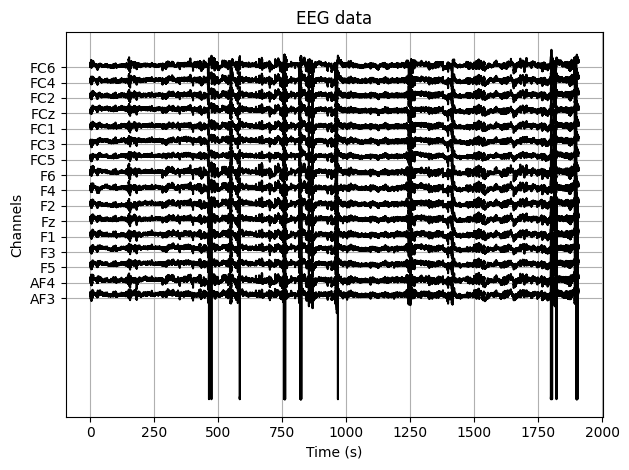

In [5]:
# Graficando el dataset
plot_eeg(
    EEG,
    ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6'],
    5000,
    'k'
)

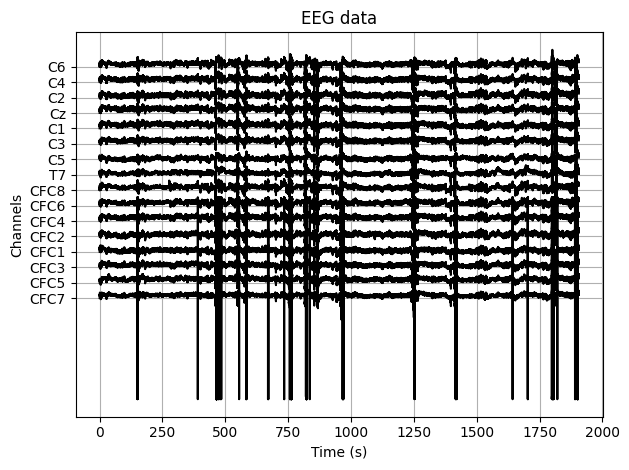

In [6]:
# Graficando el dataset
plot_eeg(
    EEG,
    ['CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6'],
    5000,
    'k'
)

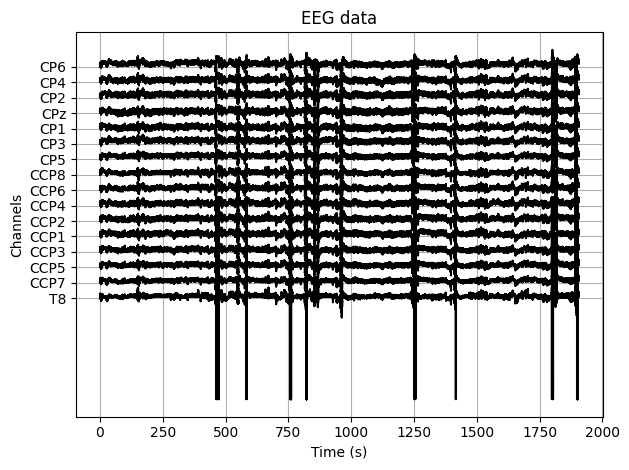

In [7]:
# Graficando el dataset
plot_eeg(
    EEG,
    ['T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6'],
    5000,
    'k'
)

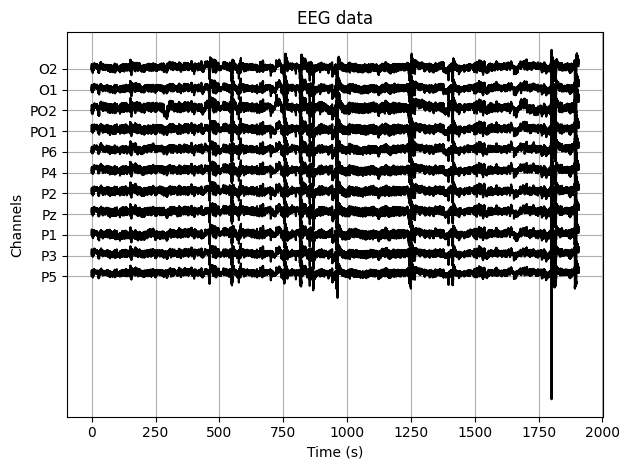

In [8]:
# Graficando el dataset
plot_eeg(
    EEG,
    ['P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2'],
    5500,
    'k'
)

## Graficar un solo canal en un rango de tiempo

In [9]:
#Función para graficar una señal de la base de datos
def graficar(x,a,inicio=0,final=-1):
    if final == -1:
        plt.plot(range(inicio,x[a].size-1),x[a][inicio:final])
    else:
        plt.plot(range(inicio,final),x[a][inicio:final])

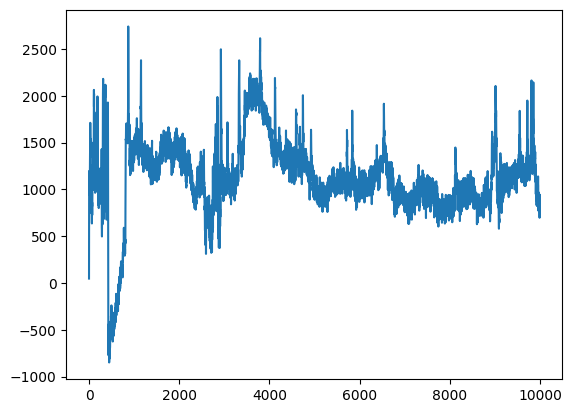

In [10]:
# Probando función
graficar(EEG,0,0,10000)

## Procesamiento de la señal

### Filtrado CAR

In [11]:
# Función para eliminar referencia promedio común (CAR) de los electrodos
def eliminar_ruido(x):
    CAR = x.mean(axis=1)
    return (x.transpose() - np.array([CAR])).transpose()

In [12]:
# Probando función
EEG = eliminar_ruido(EEG)

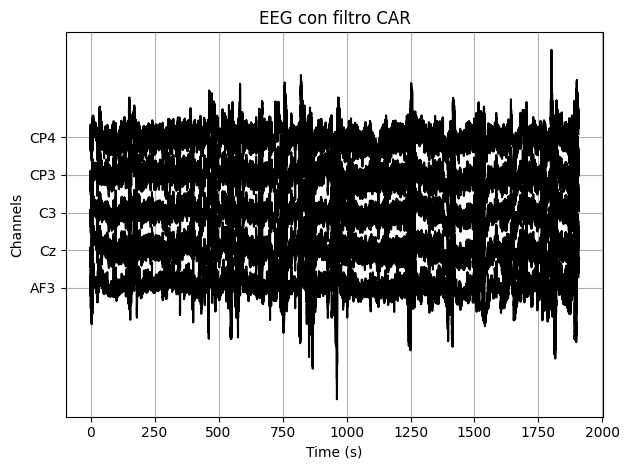

In [13]:
# Graficando el dataset filtrado CAR
plot_eeg(
    EEG,
    ['AF3','Cz','C3','CP3','CP4'],
    2000,
    'k',
    titulo = 'EEG con filtro CAR'
)

## Preparación de los eventos

In [14]:
# Separando los eventos por clases
trials = {}

# Preparación de ventana (en número de muestras) de 0.5 - 2.5 segundos
win = np.arange(int(0.5*sample_rate),int(2.5*sample_rate))
nsamples = len(win)

# Loop entre clases
for cl, code in zip(cl_lab,np.unique(event_codes)):

    # Extraer los encendidos de una clase
    cl_onsets = event_onsets[event_codes==code]

    # Ubicar en memoria los eventos
    trials[cl] = np.zeros((nchannels,nsamples,len(cl_onsets)))

    # Extraer cada evento
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:,win+onset]

# Imprimiendo información de los eventos separados por clase (canales x tiempo x evento)
print('Tamaño de evento [cl1]:',trials[cl1].shape)
print('Tamaño de evento [cl2]:',trials[cl2].shape)

Tamaño de evento [cl1]: (59, 200, 100)
Tamaño de evento [cl2]: (59, 200, 100)


### Cálculo de la Densidad Spectral de Potencia

In [15]:
def psd(trials):
    '''
    Calcula la PSD de cada trial
    
    Parámetros
    -----------------------------
    trials : Array 3D (canales x muestras x trial)

    Retornos
    ----------------------------
    trial_PSD : Array 3D (canales x PSD x trial)
    freqs : Lista de flotantes
        Frecuencia con la que fue computarizado el trial
    '''

    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels,101,ntrials))

    # Iterar sobre trials y canales
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calcular la PSD
            (PSD,freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch,:,trial] = PSD.ravel()
    
    return trials_PSD, freqs

In [16]:
# Aplicando la PSD a las dos clases
psd_1, freqs = psd(trials[cl1])
psd_2, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

In [17]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Grafica la PSD calculada con (psd).

    Parámetros
    -----------------------
    trials_PSD : Array 3D
        El PSD data
    freqs : Lista de flotantes
        Las frecuencias a las que se definió el PSD
    chan_ind : Lista de enteros
        Indica los canales a graficar
    chan_lab : Lista de cadenas
        (opcional) Lista de los nombres de los canales
    maxy : Flotante
        (opcional) : Límite del eje y
    '''

    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Máximo 3 gráficas por renglón
    nrows = int(np.ceil(nchans/3))
    ncols = min(3, nchans)

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Cuál subplot graficar
        plt.subplot(nrows,ncols,i+1)

        # Graficar el PSD para cada clase
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
        
        # Estilizar la gráfica
        # plt.xlim(1,30)

        if maxy!= None:
            plt.ylim(0,maxy)
        
        plt.grid()
        plt.xlabel('Frecuencia (Hz)')

        if chan_lab is None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])
        
        plt.legend()
    
    plt.tight_layout()

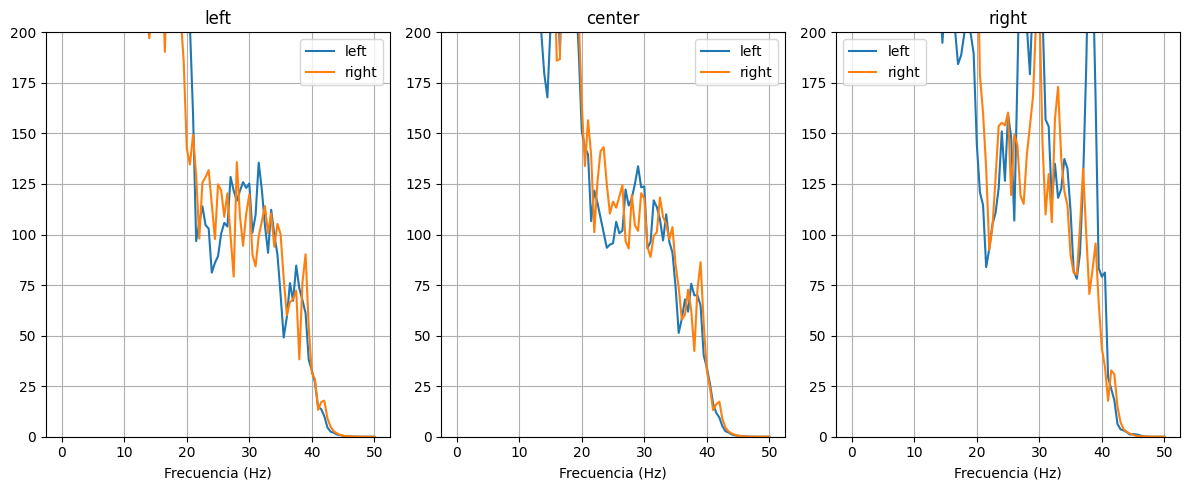

In [18]:
# Probando función plot_psd()

# 1. C3: Central, left
# 2. Cz: Central, central
# 3. C4: Central, right

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=200
)

### Filtrado de la señal

In [19]:
import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Diseña y aplica un filtro pasa banda a la señal

    Parámetros
    -----------------------
    trials : Array 3D (canales x muestras x trial)
        La señal de EEG
    lo : flotante
        Frecuencia de corte uno (Hz)
    hi : flotante
        Frecuencia de corte dos (Hz)
    sample_rate : flotante
        Frecuencia de muestreo (Hz)

    Retorno
    -----------------------
    trials_filt : Array 3D (canales x muestras x trial)
        La señal filtrada        
    '''

    a,b = scipy.signal.iirfilter(6,[lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Aplicando el filtro a cada trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels,nsamples,ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a,b,trials[:,:,i],axis=1)
    return trials_filt

In [20]:
# Probando la función
trials_filt = {cl1: bandpass(trials[cl1], 8, 30, sample_rate),cl2: bandpass(trials[cl2], 8, 30, sample_rate),}

In [21]:
trials_filt[cl1].shape

(59, 200, 100)

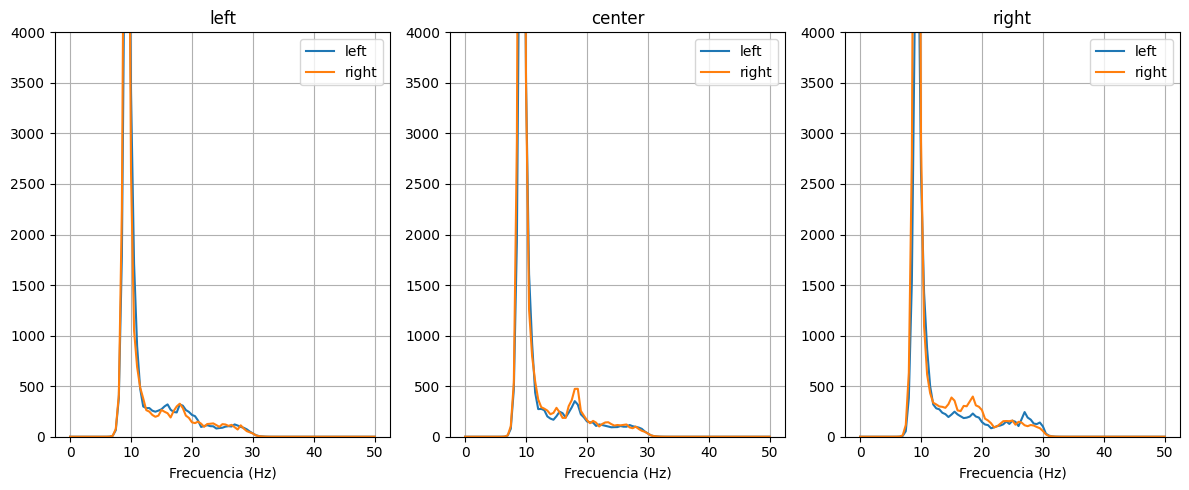

In [22]:
# Aplicando la PSD a las señales filtradas
psd_1, freqs = psd(trials_filt[cl1])
psd_2, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=4000
)

### Calcular el logaritmo de las pruebas

In [23]:
# Función para calcular el valor logaritmo de cada canal
def logvar(trials):
    '''
    Calcular el valor logaritmo de cada canal

    Parámetros
    ---------------------------
    trials: Array 3D (canales x muestras x trials)
        La señal de EEG.
    
    Retorno
    ---------------------------
    logvar : Array 2D (canales x trials)
        Para cada canal calcula su valor logarítmico
    '''

    return np.log(np.var(trials, axis=1))

In [24]:
# Probando la función
trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}

### Función para visualizar el logaritmo de cada canal

In [25]:
def plot_logvar(trials,nchannels = nchannels):
    '''
    Graficar el valor logaritmo de cada canal

    Parámetros
    -------------------
    trials : Diccionario que contiene los trials (log-vars x trials) para 2 clases.
    '''

    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var de cada canal/componente')
    plt.xlabel('Canales/componentes')
    plt.ylabel('Log-var')
    plt.legend(cl_lab)

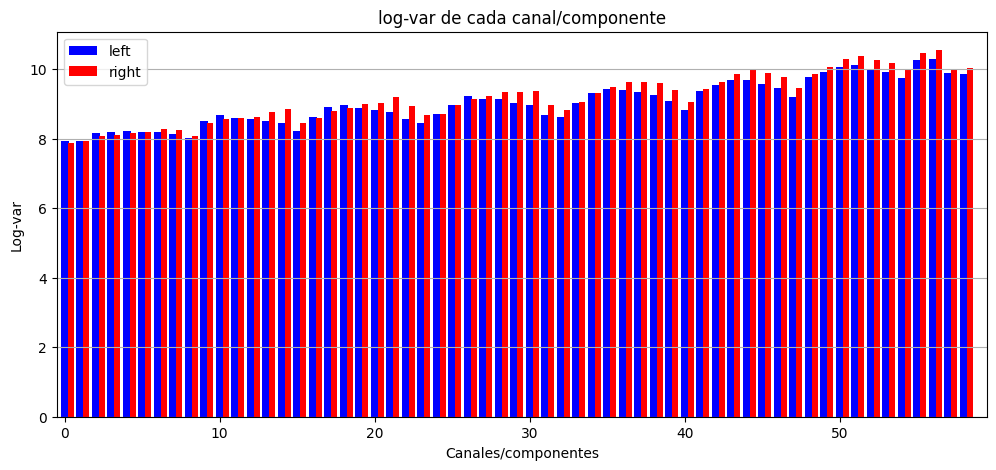

In [26]:
# Probando la función
plot_logvar(trials_logvar)

- Vemos que la mayoría de los canales muestran una pequeña diferencia en el log-var de la señal entre las dos clases.
- El siguiente paso es pasar de 59 canales a sólo unas pocas mezclas de canales.
- El algoritmo CSP calcula mezclas de canales que están diseñadas para maximizar la diferencia de variación entre dos clases.
- Estas mezclas se denominan filtros espaciales.

## Algoritmo Common Spatial Patterns (CSP)

In [27]:
from scipy import linalg
def cov(trials):
    '''Calcula la covarianza de cada prueba y entrega el promedio'''
    ntrials = trials.shape[2]
    covs = [trials[:,:,i].dot(trials[:,:,i].T) /nsamples for i in range(ntrials)]
    return np.mean(covs, axis=0)

def whitening(sigma):
    '''Calcula el whitering de una matrix de covarianza sigma'''
    U, l, _ = linalg.svd(sigma)
    return U.dot(np.diag(l ** -0.5))

def csp(trials_1, trials_2):
    '''
    Calcula la transformada CSP matriz W.

    Argumentos:
    ------------------
        trials_r : Array (canales x muestras x trials) movimientos derecha
        trials_f : Array (canales x muestras x trials) movimientos izquierda

    Retornos:
    -----------------
        Matriz mezclada W
    '''
    cov_1 = cov(trials_1)
    cov_2 = cov(trials_2)
    P = whitening(cov_1 + cov_2)
    B, _, _ = linalg.svd(P.T.dot(cov_2).dot(P))
    W = P.dot(B)
    return W

def apply_mix(W,trials):
    '''Aplica la matriz mezclada a cada trial (multiplica W con la matriz de señal EEG'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples,ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [28]:
# Probando la función
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),cl2: apply_mix(W, trials_filt[cl2])}

In [29]:
trials_csp['left'].shape

(59, 200, 100)

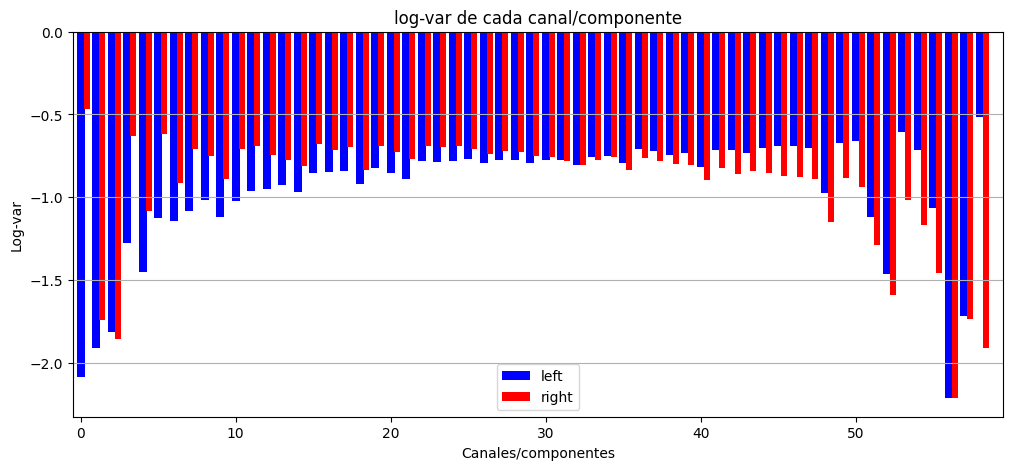

In [30]:
# Graficando log-var una vez aplicado el algoritmo CSP
trials_logvar = {cl1: logvar(trials_csp[cl1]),cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

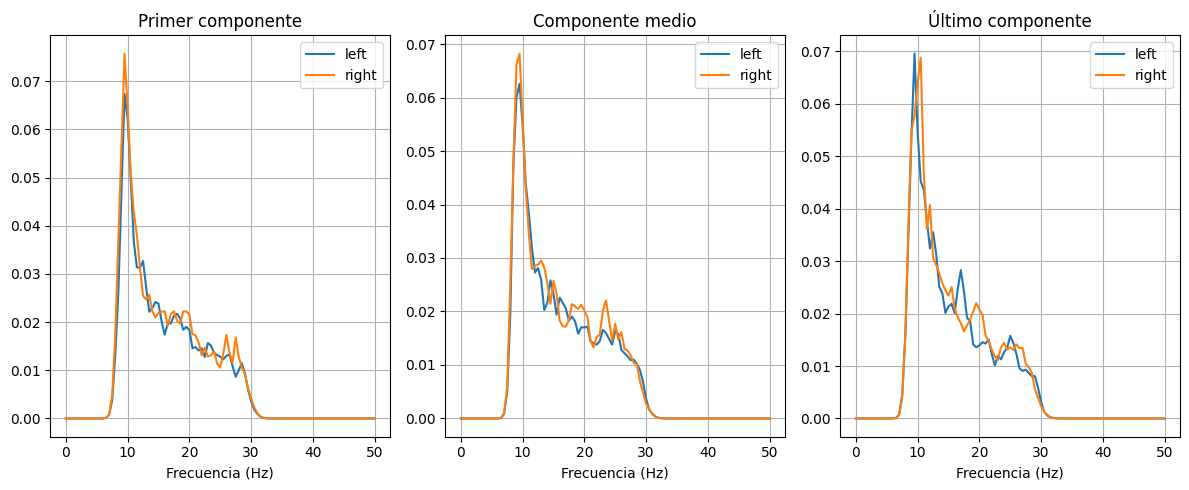

In [31]:
# Graficando PSD del CSP
psd_1, freqs = psd(trials_csp[cl1])
psd_2, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(trials_PSD, freqs, 
    [channel_names.index(ch) for ch in ['C3','Cz','C4']], chan_lab = ['Primer componente', 'Componente medio', 'Último componente'])

In [32]:
def plot_scatter(one, two):
    plt.figure()
    plt.scatter(one[0,:], one[-1,:], color='b')
    plt.scatter(two[0,:], two[-1,:], color='r')
    plt.xlabel('Último componente')
    plt.ylabel('Primer componente')
    plt.legend(cl_lab)

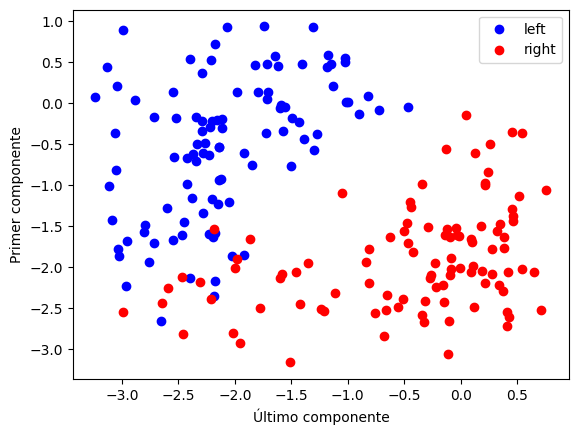

In [33]:
# Probando la función
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

## Clasificación

In [34]:
# Porcentaje de pruebas para usarse en el entranmiento
train_percentage = 0.7

In [35]:
# Calcular el número de pruebas por clase por porcentaje elegido
ntrain_1 = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_2 = int(trials_filt[cl2].shape[2] * train_percentage)

ntest_1 = trials_filt[cl1].shape[2] - ntrain_1
ntest_2 = trials_filt[cl2].shape[2] - ntrain_2

In [36]:
# Seaparando la señal filtrada en entrenamiento y prueba
train = {cl1: trials_filt[cl1][:,:,:ntrain_1],
cl2: trials_filt[cl2][:,:,:ntrain_2]}

test = {cl1: trials_filt[cl1][:,:,ntrain_1:],
cl2: trials_filt[cl2][:,:,ntrain_2:]}

In [37]:
test[cl1].shape

(59, 200, 30)

In [38]:
# Entrenar el CSP únicamente con el set de entrenamiento
W = csp(train[cl1], train[cl2])

In [39]:
train[cl1].shape

(59, 200, 70)

In [40]:
W.shape

(59, 59)

In [41]:
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

In [42]:
train[cl1].shape

(59, 200, 70)

In [43]:
comp = np.array([0,-1])

ftrain = {cl1:[],cl2:[]}
ftrain[cl1] = train[cl1][comp,:,:]
ftrain[cl2] = train[cl2][comp,:,:]
ftest = {cl1:[],cl2:[]}
ftest[cl1] = test[cl1][comp,:,:]
ftest[cl2] = test[cl2][comp,:,:]

In [44]:
ftrain[cl1].shape

(2, 200, 70)

In [45]:
ftest[cl1].shape

(2, 200, 30)

In [46]:
train[cl1] = logvar(ftrain[cl1])
train[cl2] = logvar(ftrain[cl2])
test[cl1] = logvar(ftest[cl1])
test[cl2] = logvar(ftest[cl2])

In [47]:
train[cl2].shape

(2, 70)

In [48]:
ftest[cl1].shape

(2, 200, 30)

In [49]:
x_train = np.concatenate([train[cl1].T , train[cl2].T])
x_test = np.concatenate([test[cl1].T, test[cl2].T])

x_test.shape

(60, 2)

In [50]:
y_train = np.concatenate([np.zeros(ntrain_1), np.ones(ntrain_2)])
y_test = np.concatenate([np.zeros(ntest_1), np.ones(ntest_2)])
y_train.shape

(140,)

In [51]:
y_test.shape

(60,)

In [52]:
# Convertir el array de salidas a una codificación one_ hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
# Cambiamos el y_train a una forma (numero de datos, etiqueta categorica)
y_train = y_train.reshape(len(y_train), 1)
# Y cambiamos a un vector one-hot
y_train_onehot = onehot_encoder.fit_transform(y_train)

# # Cambiamos el y_test a una forma (numero de datos, etiqueta categorica)
y_test = y_test.reshape(len(y_test), 1)
# Y cambiamos a un vector one-hot
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_test_onehot.shape

(60, 2)

## Declarando la arquitectura con Keras

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [54]:
# Graficar la arquitectura de la red
modelo = model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

Antes de que el modelo este listo para entrenar , se necesitan algunas configuraciones más. Éstas son agregadas durante el paso de compilacion del modelo:

+ Loss function: Mide qué tan exacto es el modelo. Se busca minimizar su valor para dirigir el modelo en la dirección adecuada.
+ Optimizer: Cómo el modelo se actualiza basado en el set de datos que ve y la función de pérdida. Por default el factor de aprendizaje es de 0.001
+ Metrics: Métricas de validación, monitorean los pasos de entrenamiento y pruebas. El accuracy (exactitud), arroja la fración de entradas correctamente clasificadas.

In [55]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
model.fit(x_train, y=y_train_onehot, batch_size =100, epochs=15, shuffle=True)

Epoch 1/15
2/2 [==============================] - 1s 4ms/step - loss: 0.7000 - accuracy: 0.4357
Epoch 2/15
2/2 [==============================] - 0s 5ms/step - loss: 0.6209 - accuracy: 0.9571
Epoch 3/15
2/2 [==============================] - 0s 3ms/step - loss: 0.5552 - accuracy: 0.9643
Epoch 4/15
2/2 [==============================] - 0s 3ms/step - loss: 0.5000 - accuracy: 0.9643
Epoch 5/15
2/2 [==============================] - 0s 3ms/step - loss: 0.4501 - accuracy: 0.9643
Epoch 6/15
2/2 [==============================] - 0s 4ms/step - loss: 0.4067 - accuracy: 0.9643
Epoch 7/15
2/2 [==============================] - 0s 4ms/step - loss: 0.3682 - accuracy: 0.9643
Epoch 8/15
2/2 [==============================] - 0s 3ms/step - loss: 0.3334 - accuracy: 0.9643
Epoch 9/15
2/2 [==============================] - 0s 4ms/step - loss: 0.3021 - accuracy: 0.9643
Epoch 10/15
2/2 [==============================] - 0s 4ms/step - loss: 0.2733 - accuracy: 0.9643
Epoch 11/15
2/2 [======================

In [57]:
train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=2)

print('\nExactitud en el entrenamiento:', train_acc, '\nPérdida en el entrenamiento:', train_loss, )

5/5 - 0s - loss: 0.1592 - accuracy: 0.9643 - 181ms/epoch - 36ms/step

Exactitud en el entrenamiento: 0.9642857313156128 
Pérdida en el entrenamiento: 0.1591866910457611


In [58]:
test_loss, test_acc = model.evaluate(x_test,  y_test_onehot, verbose=2)

print('\nExactitud en la prueba:', test_acc, '\nPérdida en la prueba:', test_loss,)

2/2 - 0s - loss: 0.1958 - accuracy: 0.9333 - 29ms/epoch - 14ms/step

Exactitud en la prueba: 0.9333333373069763 
Pérdida en la prueba: 0.19578833878040314


2/2 [==============================] - 0s 2ms/step


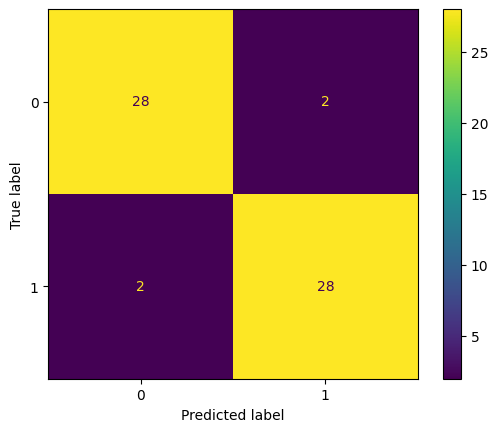

In [59]:
predictions = model.predict(x_test)
predictions2 = np.array([np.argmax(c) for p,c in enumerate(predictions)])

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

In [60]:
label_dict = {0: cl_lab[0],
              1: cl_lab[1]}

In [61]:
validacion = 30
predictions[validacion]
res_predictor = np.argmax(predictions[validacion])
res_real = y_test[validacion]
print('El predictor arroja una clase de tipo:', label_dict[res_predictor], ', la clase real es:', label_dict[int(res_real)], '.')

El predictor arroja una clase de tipo: right , la clase real es: right .


### Extracción de características

In [62]:
# Función de extracción de características
def statistics_feature_extraction(x):
    import math
    import numpy as np

    vector_caracteristicas = []
    xsize = x.shape[0]

    #F1: Promedio
    promedio=x.mean()
    vector_caracteristicas.append(promedio)
    #F2: Promedio absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[0]))
    #F3: Máximo
    vector_caracteristicas.append(max(x))
    #F4: Máximo absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[2]))
    # #F5: Mínimo
    vector_caracteristicas.append(min(x))
    #F6: Mínimo absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[4]))
    #F7: Máximo + Mínimo
    vector_caracteristicas.append(vector_caracteristicas[2]+vector_caracteristicas[4])
    #F8: Máximo - Mínimo
    vector_caracteristicas.append(vector_caracteristicas[2]-vector_caracteristicas[4])

    #F9: ELIMINADA

    #F10: Longitud de curva
    sumita=0
    for i in range(xsize-1):
        sumita=sumita+abs(x[i+1]-x[i])
    vector_caracteristicas.append(sumita)
    #F11: Energía
    sumita=0
    for i in range(xsize):
        sumita=sumita+(x[i]**2)
    vector_caracteristicas.append(sumita/xsize)
    #F12: Energía no lineal promedio (ANE)
    sumita=0
    for i in range(xsize-2):
        sumita=sumita+((x[i+1]**2)-(x[i]*x[i+2]))
    vector_caracteristicas.append(sumita/xsize-2)
    #F13: Entropía espectral (SE)
    sumita=0
    for i in range(xsize):
        pk=(abs(x[i]**2))/(xsize*1.5)
        sumita=sumita+(pk*math.log2(pk))
    vector_caracteristicas.append(sumita)

    #F14: ELIMINADA

    #F15: Integral
    sumita=0
    for i in range(xsize):
        sumita=sumita+abs(x[i])
    vector_caracteristicas.append(sumita)
    #F16: Desviación estándar
    desv=x.std()
    vector_caracteristicas.append(desv)
    #F17: Varianza
    vector_caracteristicas.append(x.var())
    #F18: Oblicuidad
    sumita=0
    for i in range(xsize):
        sumita=sumita+(((x[i]-promedio)/desv)**3)
    vector_caracteristicas.append(sumita/xsize)
    #F19: Curtosis
    sumita=0
    for i in range(xsize):
        sumita=sumita+(((x[i]-promedio)/desv)**4)
    vector_caracteristicas.append(sumita/xsize)
    #F20: Sumatoria
    sumita=0
    for i in range(xsize):
        sumita=sumita+x[i]
    vector_caracteristicas.append(sumita)
    #F21: Mediana
    vector_caracteristicas.append(np.median(x))
    return vector_caracteristicas

In [63]:
def fe_trials(ftrain,train):
    cuantificador = np.zeros((train.shape[0],2,20))
    for i,a in enumerate(ftrain[:,0,0]):
        for j,b in enumerate(ftrain[0,0,:]):
            vector = statistics_feature_extraction(ftrain[i,:,j])
            cuantificador[j,i,:] = np.concatenate((vector,[train[j,i]]))
    return cuantificador

In [64]:
# Seaparando la señal filtrada en entrenamiento y prueba
ftrain = {cl1: fe_trials(ftrain[cl1],train[cl1].T),
cl2: fe_trials(ftrain[cl2],train[cl2].T)}

ftest = {cl1: fe_trials(ftest[cl1],test[cl1].T),
cl2: fe_trials(ftest[cl2],test[cl2].T)}

In [65]:
ftest[cl1].shape

(30, 2, 20)

In [66]:
ftrain[cl1].shape

(70, 2, 20)

In [67]:
x_train = np.concatenate([ftrain[cl1] , ftrain[cl2]])
x_test = np.concatenate([ftest[cl1], ftest[cl2]])

x_test.shape

(60, 2, 20)

In [68]:
x_train=x_train.reshape(-1,2*20).astype('float32')
x_test=x_test.reshape(-1,2*20).astype('float32')
x_train.shape

(140, 40)

In [69]:
y_train_onehot.shape

(140, 2)

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(40,), activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [71]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model.fit(x_train, y=y_train_onehot, batch_size =100, epochs=15, shuffle=True)

Epoch 1/15
2/2 [==============================] - 0s 5ms/step - loss: 6.1784 - accuracy: 0.5071
Epoch 2/15
2/2 [==============================] - 0s 3ms/step - loss: 0.5809 - accuracy: 0.8143
Epoch 3/15
2/2 [==============================] - 0s 3ms/step - loss: 0.6241 - accuracy: 0.8143
Epoch 4/15
2/2 [==============================] - 0s 4ms/step - loss: 0.1605 - accuracy: 0.9571
Epoch 5/15
2/2 [==============================] - 0s 5ms/step - loss: 0.1114 - accuracy: 0.9571
Epoch 6/15
2/2 [==============================] - 0s 3ms/step - loss: 0.1330 - accuracy: 0.9500
Epoch 7/15
2/2 [==============================] - 0s 4ms/step - loss: 0.1667 - accuracy: 0.9571
Epoch 8/15
2/2 [==============================] - 0s 4ms/step - loss: 0.1845 - accuracy: 0.9571
Epoch 9/15
2/2 [==============================] - 0s 4ms/step - loss: 0.1675 - accuracy: 0.9500
Epoch 10/15
2/2 [==============================] - 0s 4ms/step - loss: 0.1314 - accuracy: 0.9571
Epoch 11/15
2/2 [======================

In [73]:
train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=2)

print('\nExactitud en el entrenamiento:', train_acc, '\nPérdida en el entrenamiento:', train_loss, )

5/5 - 0s - loss: 0.1142 - accuracy: 0.9571 - 154ms/epoch - 31ms/step

Exactitud en el entrenamiento: 0.9571428298950195 
Pérdida en el entrenamiento: 0.11416109651327133


In [74]:
test_loss, test_acc = model.evaluate(x_test,  y_test_onehot, verbose=2)

print('\nExactitud en la prueba:', test_acc, '\nPérdida en la prueba:', test_loss, )

2/2 - 0s - loss: 0.3424 - accuracy: 0.9000 - 27ms/epoch - 14ms/step

Exactitud en la prueba: 0.8999999761581421 
Pérdida en la prueba: 0.34239476919174194


2/2 [==============================] - 0s 3ms/step


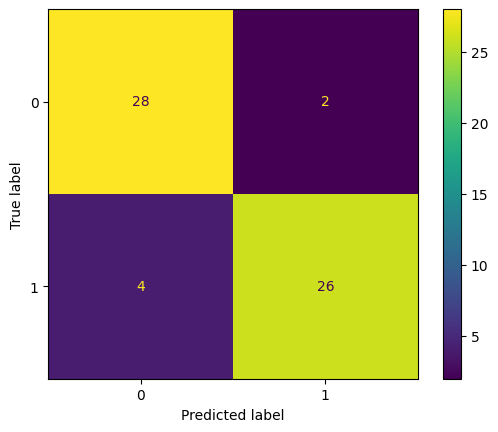

In [75]:
predictions = model.predict(x_test)
predictions2 = np.array([np.argmax(c) for p,c in enumerate(predictions)])

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

## Red Neuronal Convolucional CNN

In [76]:
# Seaparando la señal filtrada en entrenamiento y prueba
train = {cl1: trials_filt[cl1][:,:,:ntrain_1],
cl2: trials_filt[cl2][:,:,:ntrain_2]}

test = {cl1: trials_filt[cl1][:,:,ntrain_1:],
cl2: trials_filt[cl2][:,:,ntrain_2:]}

In [77]:
test[cl1].T.shape

(30, 200, 59)

In [78]:
x_train = np.concatenate([train[cl1].T , train[cl2].T])
x_test = np.concatenate([test[cl1].T, test[cl2].T])

x_test.shape

(60, 200, 59)

In [79]:
from sklearn.preprocessing import StandardScaler

def estandarizar(señal):
    neo = np.ones((señal.T.shape))
    for ch in range(señal.shape[2]):
        scaler = StandardScaler()
        model = scaler.fit(señal.T[ch])
        scaled_data = model.transform(señal.T[ch])
        neo[ch] = scaled_data
    return neo.T

In [80]:
x_train = estandarizar(x_train)
x_test = estandarizar(x_test)

In [81]:
y_train = np.concatenate([np.zeros(ntrain_1), np.ones(ntrain_2)])
y_test = np.concatenate([np.zeros(ntest_1), np.ones(ntest_2)])
y_train.shape

(140,)

In [82]:
model_cnn = tf.keras.Sequential()

model_cnn.add(tf.keras.layers.Conv1D(8, (3), activation='tanh', input_shape=(200, 59) , padding='same'))
model_cnn.add(tf.keras.layers.MaxPooling1D((2)))
model_cnn.add(tf.keras.layers.Conv1D(16, (3), activation='tanh', padding= 'same'))
model_cnn.add(tf.keras.layers.MaxPooling1D((2)))
model_cnn.add(tf.keras.layers.Conv1D(16, (3), activation='relu', padding= 'same'))
model_cnn.add(tf.keras.layers.MaxPooling1D((2)))


model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(32, activation= 'relu'))
# model_cnn.add(tf.keras.layers.Dense(16, activation= 'relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [83]:
model_cnn.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_cnn.fit(x_train, y_train, batch_size=8, shuffle=True, epochs=30,validation_data=(x_test, y_test))

Epoch 1/30
18/18 [==============================] - 1s 20ms/step - loss: 0.7060 - accuracy: 0.4857 - val_loss: 0.6891 - val_accuracy: 0.5500
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.6630 - accuracy: 0.5857 - val_loss: 0.6933 - val_accuracy: 0.5500
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.6018 - accuracy: 0.7571 - val_loss: 0.6966 - val_accuracy: 0.4833
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 0.5533 - accuracy: 0.8357 - val_loss: 0.7043 - val_accuracy: 0.5000
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.5123 - accuracy: 0.8714 - val_loss: 0.7030 - val_accuracy: 0.5167
Epoch 6/30
18/18 [==============================] - 0s 7ms/step - loss: 0.4713 - accuracy: 0.8643 - val_loss: 0.7110 - val_accuracy: 0.5167
Epoch 7/30
18/18 [==============================] - 0s 7ms/step - loss: 0.4103 - accuracy: 0.8929 - val_loss: 0.7190 - val_accuracy: 0.5333
Epoch 8/30
18/18 [=

In [84]:
# Graficar la arquitectura de la red
modelo = model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 8)            1424      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 16)            784       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 16)          

2/2 [==============================] - 0s 6ms/step


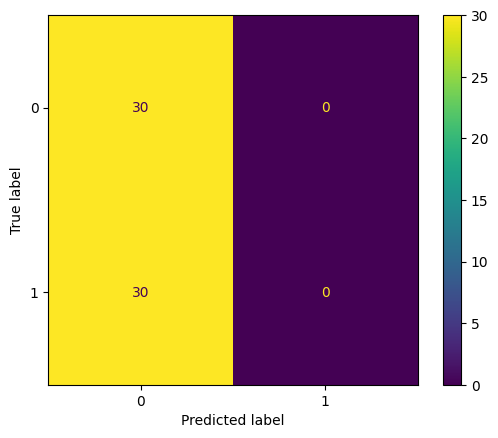

In [85]:
predictions = model_cnn.predict(x_test)
predictions2 = np.array([np.argmax(c) for p,c in enumerate(predictions)])

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

## Máquinas de soporte vectorial

In [86]:
# Seaparando la señal filtrada en entrenamiento y prueba
train = {cl1: trials_filt[cl1][:,:,:ntrain_1],
cl2: trials_filt[cl2][:,:,:ntrain_2]}

test = {cl1: trials_filt[cl1][:,:,ntrain_1:],
cl2: trials_filt[cl2][:,:,ntrain_2:]}

In [87]:
# Entrenar el CSP únicamente con el set de entrenamiento
W = csp(train[cl1], train[cl2])

In [88]:
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

In [89]:
comp = np.array([0,-1])

ftrain = {cl1:[],cl2:[]}
ftrain[cl1] = train[cl1][comp,:,:]
ftrain[cl2] = train[cl2][comp,:,:]
ftest = {cl1:[],cl2:[]}
ftest[cl1] = test[cl1][comp,:,:]
ftest[cl2] = test[cl2][comp,:,:]

In [90]:
train[cl1] = logvar(ftrain[cl1])
train[cl2] = logvar(ftrain[cl2])
test[cl1] = logvar(ftest[cl1])
test[cl2] = logvar(ftest[cl2])

In [91]:
x_train = np.concatenate([train[cl1].T , train[cl2].T])
x_test = np.concatenate([test[cl1].T, test[cl2].T])

x_test.shape

(60, 2)

In [92]:
y_train = np.concatenate([np.zeros(ntrain_1), np.ones(ntrain_2)])
y_test = np.concatenate([np.zeros(ntest_1), np.ones(ntest_2)])
y_train.shape

(140,)

In [93]:
from sklearn import svm

In [94]:
modelo = svm.SVC(kernel='linear')

In [95]:
modelo.fit(x_train,y_train)

SVC(kernel='linear')

In [106]:
def plot_scatter(one, two):
    plt.figure()
    plt.scatter(one[0,:], one[-1,:], color='b')
    plt.scatter(two[0,:], two[-1,:], color='r')
    plt.xlabel('Último componente')
    plt.ylabel('Primer componente')
    plt.legend(cl_lab)

# Constructing a hyperplane using a formula.
    w = modelo.coef_[0]           # w consists of 2 elements
    b = modelo.intercept_[0]      # b consists of 1 element


    x_points = np.linspace(-3, 1)    # generating x-points from -1 to 1
    y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points

    # Plotting a red hyperplane
    plt.plot(x_points, y_points, c='k');

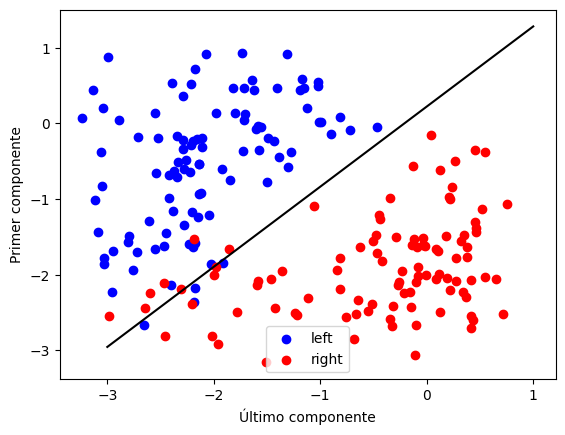

In [107]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [98]:
yf = modelo.predict(x_test)
yf [0:5]
print("Primera predicción: ",yf)
print("Datos reales: ",y_test)

Primera predicción:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
Datos reales:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<img src="f1_score.png">

In [99]:
# Evaluar del modelo con puntaje F1
from sklearn.metrics import f1_score

In [100]:
print("Puntaje F1: %.4f" % f1_score(y_test, yf, pos_label=0))

Puntaje F1: 0.9333


In [101]:
print("Puntaje F1: %.4f" % f1_score(y_test, yf, pos_label=1))

Puntaje F1: 0.9333


<img src="jaccard_similarity.jpg">

In [102]:
# Evaluación del modelo con Índice de Jaccard
from sklearn.metrics import jaccard_score

In [103]:
# Puntaje de la clase 0
jaccard_score(y_test, yf, pos_label=0)
print("Jaccard Índice: %.4f" % jaccard_score(y_test, yf, pos_label=0))

Jaccard Índice: 0.8750


In [104]:
# Puntaje de la clase 1
jaccard_score(y_test, yf, pos_label=1)
print("Jaccard Índice: %.4f" % jaccard_score(y_test, yf, pos_label=1))

Jaccard Índice: 0.8750


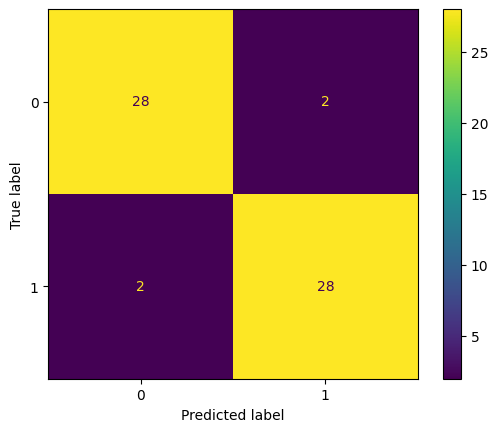

In [105]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, yf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()